In [ ]:
#let's train a MLP regression model using this data "dm_office_sales.csv"
#for that we will first separate out X ie features from label ie y
#then we will Train/Test split the data
#we don't need to normalize continuous valued output column/target label
#as that's what we want to predict in the real-world, hence don't change its value
#then we will fit a normalization model on feature vectors only of Train data ir X_Train by calling fit()
#as we do not want to assume any information from the Test dataset otherwise it will result in data leakage
#we do not want any information leaking from the Test dataset or pre-conceived distribution of Test set, 
# so we use fit() method of StandardScaler for X_Train only
# Then it basically learns mean and standard deviation of Train dataset, to scale X_train values feature wise mean centered 
#use this Normalizer object on feature vectors only of Test data ie X_Test by calling transform() 
#as we want to handle pre-processing of X_Train/X_Test using handled similar methods
#our objective is to predict sales using 5 input features where first 2 features are categorical, and next 3 features are numeric
#also each numeric feature is measuring things under different units

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error,r2_score,make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [77]:
df=pd.read_csv("dm_office_sales.csv")

In [78]:
df.head()

,division,level of education,training level,work experience,salary,sales
0,printers,some college,2,6,91684,372302
1,printers,associate's degree,2,10,119679,495660
2,peripherals,high school,0,9,82045,320453
3,office supplies,associate's degree,2,5,92949,377148
4,office supplies,high school,1,5,71280,312802


In [79]:
df.shape

(1000, 6)

In [80]:
X=df.iloc[:,:-1] #.values
y=df.iloc[:,-1] #.values #turn df to NumPy array

In [ ]:
#help(train_test_split)

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#if we want to compare multiple ml models, they must have same train/test split, 
#i.e. same Train data and Test data
# random state ="same number" ensures it.
#if you want to run multiple experiments
#each with a new Train/Test data
#keep changing the value of random_state option

In [82]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder=OneHotEncoder(sparse_output=False,drop='first')
#drop=first to avoid dummy variable trap
#scaler=StandardScaler()


In [83]:
X_train

,division,level of education,training level,work experience,salary
541,computer hardware,associate's degree,2,5,96469
440,printers,some college,1,5,79385
482,computer hardware,bachelor's degree,2,1,82926
422,office supplies,associate's degree,2,5,92369
778,peripherals,some college,2,3,78273
...,...,...,...,...,...
106,printers,associate's degree,1,7,96834
270,printers,high school,1,2,58603
860,computer hardware,high school,3,4,95202
435,peripherals,high school,3,9,105047


In [84]:
#fit OHE categorical columns for X_train
encoder.fit(X_train[['division','level of education']])

,categories,'auto'
,drop,'first'
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [85]:
X_train=encoder.transform(X_train[['division','level of education']])

In [86]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(700, 8))

In [87]:
# Pipeline definition
steps = [
    ('scaler', StandardScaler()),            # Standardize features
    ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor
]
pipeline = Pipeline(steps=steps)


In [88]:
# Parameter grid for RandomForestRegressor
param_grid = {
    'rf__n_estimators': [300],#[100, 200, 500],
    'rf__max_depth': [5],#[None, 5, 10, 20],
    'rf__min_samples_split': [5],#[2, 5, 10],
    'rf__min_samples_leaf': [5],#[1, 2, 4],
    'rf__max_features': ['log2'],#['auto', 'sqrt', 'log2', None],
    'rf__bootstrap': [False],#[True, False]
}

In [89]:
# Multiple scoring metrics for regression
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

In [90]:
# Grid search with multiple scoring and refit on R2 score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring=scoring,
    refit='r2',               # refit based on R2 score
    n_jobs=-1,
    verbose=1
)

In [91]:
# Now repeat same steps for X_Test, doing it separately for 
# it saves data leakage and pre-assumes nothing about Test data 
#for deployment you will get Test data separately
X_test=encoder.transform(X_test[['division','level of education']])
#X_test_numeric_scaled=scaler.transform(X_test[['training level','work experience','salary']])
#X_test_transf=np.hstack((encoded_data_ohe_test,X_test_numeric_scaled))


In [92]:
#we need to normalize y_train and y_test too 
#otherwise unstable training wiould result
#all input features are in same range -2 to 2 or 0 to 1
#let's normalize target label now
scaler1=StandardScaler()
#scaler1.fit(y_train) 
# gives error as scaler1 is expecting a 2-D matrix with one column
#as target label is just one column

# Reshape y_train to 2D matrix with one column before fitting 
y_train = scaler1.fit_transform(y_train.values.reshape(-1, 1)) #here - 1 can be replaced by 700
#for 70:30 Train/Test split

# Transform y_test using the fitted scaler
y_test = scaler1.transform(y_test.values.reshape(-1, 1)) #here -1 can be replaced by 300

In [93]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


d:\msc_dwm_lab_2024\msc_env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,estimator,Pipeline(step..._state=111))])
,param_grid,"{'rf__bootstrap': [False], 'rf__max_depth': [5], 'rf__max_features': ['log2'], 'rf__min_samples_leaf': [5], ...}"
,scoring,"{'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'r2'
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [94]:
estimators = grid_search.cv_results_['params']
estimators_df=pd.DataFrame(estimators)

In [95]:
estimators_df.head()

,rf__bootstrap,rf__max_depth,rf__max_features,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators
0,False,5,log2,5,5,300


In [96]:
all_estimators = grid_search.cv_results_
cv_results_df=pd.DataFrame(grid_search.cv_results_)

In [97]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__bootstrap,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,...,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.569621,0.027369,0.032034,0.00587,False,5,log2,5,5,300,...,-0.720626,-0.706382,-0.868092,-0.774946,-0.809818,-0.885083,-0.894873,-0.808995,0.061461,1


In [98]:
# Get best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


In [99]:
# Get best model from grid search
best_model = grid_search.best_estimator_

In [106]:
y_pred=best_model.predict(X_test)

In [108]:
y_test.shape

(300, 1)

In [109]:
y_pred.shape

(300,)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error,r2_score


mean_absolute_error(y_test,y_pred)
mean_squared_error(y_test,y_pred)
root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

R-squared: -0.039


In [112]:
y_test=y_test.squeeze()

In [113]:
y_test.shape

(300,)

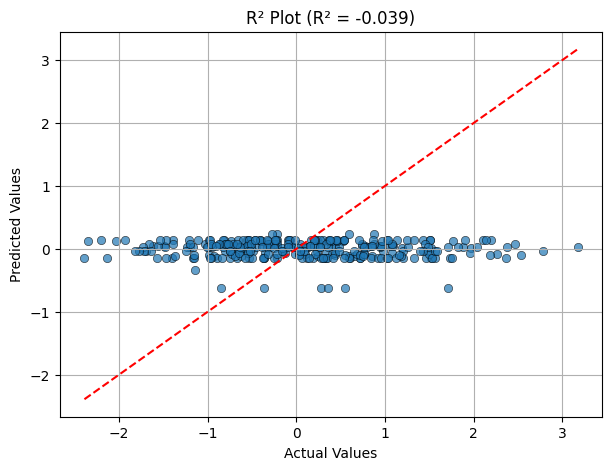

In [114]:
#plotting R-square plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor='k')  # Scatter plot of actual vs predicted
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')  # Ideal 1:1 line

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"R² Plot (R² = {r2:.3f})")
plt.grid(True)
plt.show()

In [ ]:
# Define scoring metrics, by default CV tries to maximize scoring options
#but when you want it to minimize it
#you need to set flag greater_is_better as False
scoring2 = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False)
}

In [27]:
y_train_scaled.shape

(670, 1)

In [28]:
y_test_scaled.shape

(330, 1)

In [52]:
#perform 10 fold cross validatio to learn best model
from sklearn.model_selection import cross_validate

scores=cross_validate(model,X_train_transf,y_train_scaled,scoring=scoring,cv=10,return_estimator=True,return_train_score=True,verbose=1)

d:\msc_dwm_lab_2024\msc_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\msc_dwm_lab_2024\msc_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\msc_dwm_lab_2024\msc_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\msc_dwm_lab_2024\msc_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A colu

In [53]:
scores

{'fit_time': array([0.24981046, 0.31299901, 0.20261145, 0.27868676, 0.37060833,
        0.28920412, 0.42800593, 0.51261973, 0.4118576 , 0.33670712]),
 'score_time': array([0.00543952, 0.00100017, 0.00100112, 0.00199652, 0.00579906,
        0.0019207 , 0.00794196, 0.00200057, 0.00097561, 0.00100064]),
 'estimator': [MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, solver='lbfgs'),
  MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, solver='lbfgs'),
  MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, solver='lbfgs'),
  MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, solver='lbfgs'),
  MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, solver='lbfgs'),
  MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
               random_state=42, 

In [54]:
scores_df=pd.DataFrame(scores)

In [55]:
scores_df

,fit_time,score_time,estimator,test_MAE,train_MAE,test_MSE,train_MSE
0,0.249810,0.005440,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.179820,-0.166524,-0.051398,-0.045753
1,0.312999,0.001000,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.205534,-0.160814,-0.064951,-0.043178
2,0.202611,0.001001,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.204347,-0.164903,-0.078321,-0.045266
3,0.278687,0.001997,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.197519,-0.166015,-0.061538,-0.045380
4,0.370608,0.005799,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.186644,-0.159684,-0.058241,-0.042113
5,0.289204,0.001921,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.199132,-0.163804,-0.064586,-0.044702
6,0.428006,0.007942,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.239718,-0.156037,-0.093793,-0.041332
7,0.512620,0.002001,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.236946,-0.161554,-0.084128,-0.043981
8,0.411858,0.000976,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.202079,-0.164815,-0.061874,-0.044264
9,0.336707,0.001001,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.253016,-0.157123,-0.105181,-0.040196


In [56]:
scores_df['test_MSE'].max()

-0.05139826640066835

In [57]:
scores_df['test_MAE'].max()

-0.17982026663785225

In [58]:
best_model_idx = scores_df['test_MSE'].idxmax()  

In [59]:
best_model_idx

0

In [60]:
# now use this best model out of 10 fold cross validation to do prediction on Test data
best_model=scores_df.iloc[0,2] #estimator column has index 2 in scores_df

In [96]:
y_pred=best_model.predict(X_test_transf)

In [97]:
y_pred.shape

(330,)

In [98]:
y_pred

array([ 1.20316255e+00,  3.93674204e-01, -1.27372547e+00,  4.60106268e-01,
        4.70368924e-02,  1.01874787e+00,  3.09320941e-02,  7.07764013e-01,
       -5.62471565e-01, -1.54494576e+00,  1.13316726e-01,  7.95086512e-01,
        1.05401029e+00, -3.30589935e-01, -4.16968299e-01,  9.52168826e-01,
        6.41577228e-02,  4.42480933e-02,  1.84148551e+00, -1.34213691e+00,
        1.75026357e+00,  2.20450334e+00,  1.64755373e+00,  2.98779802e-01,
       -9.11153956e-01, -1.00954423e+00,  5.69213648e-01, -6.11716849e-01,
       -9.76901762e-01,  6.61121686e-01, -6.63874642e-01, -4.17558504e-01,
       -4.82894176e-01, -8.86844352e-01,  4.43851100e-01, -6.97171171e-01,
       -7.96336222e-01,  1.75350652e-01,  8.23616021e-01,  2.24812097e-01,
       -9.90344408e-01, -2.49142444e-01,  1.36536884e+00,  1.77550630e-01,
        6.25676883e-01, -7.80837831e-01,  7.54243522e-01, -8.85028950e-01,
       -1.54825197e+00, -1.05931247e+00,  1.08695637e+00,  2.03951656e+00,
       -1.17725389e-01,  

In [100]:
y_test.shape

(330,)

In [102]:
y_pred.shape

(330,)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error,r2_score
# Get best model from grid search
best_model = grid_search.best_estimator_
mean_absolute_error(y_test_scaled,y_pred)
mean_squared_error(y_test_scaled,y_pred)
root_mean_squared_error(y_test_scaled,y_pred)
r2 = r2_score(y_test_scaled, y_pred)
print(f"R-squared: {r2:.3f}")

Each blue dot represents an (actual, predicted) pair.
Red dashed line represents the perfect fit (ideal case where y_pred = y_actual).
R² Score (R-squared) indicates how well the model explains variance:
R² = 1 → Perfect fit.
R² > 0.9 → Very good model.
R² ≈ 0.5 → Moderate fit.
R² < 0.2 → Poor fit.

In [74]:
r2 = r2_score(y_test_scaled, y_pred)
print(f"R-squared: {r2:.3f}")

R-squared: 0.945


In [76]:
y_pred.shape

(330,)

In [77]:
y_test_scaled.shape

(330, 1)

In [83]:
y_test_scaled=y_test_scaled.flatten()

In [84]:
y_test_scaled.shape

(330,)

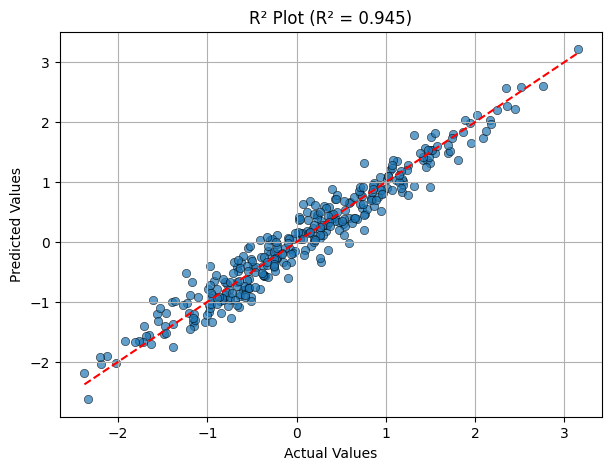

In [85]:
#plotting R-square plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test_scaled, y=y_pred, alpha=0.7, edgecolor='k')  # Scatter plot of actual vs predicted
sns.lineplot(x=y_test_scaled, y=y_test_scaled, color='red', linestyle='--')  # Ideal 1:1 line

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"R² Plot (R² = {r2:.3f})")
plt.grid(True)
plt.show()

In [103]:
# Convert predictions back to original scale
y_pred_original = scaler1.inverse_transform(y_pred.reshape(-1,1))
#why scaler1, as we fit it on y_train data after reshaping it in 1 column
#scaler1 is expecting a 2D matrix with just 1 column

In [104]:
y_pred_original

array([[467563.74165419],
       [380143.49337172],
       [200073.58234157],
       [387317.78751608],
       [342708.58751026],
       [447647.98017397],
       [340969.35866706],
       [414063.44958636],
       [276885.05687994],
       [170783.29602644],
       [349866.44173786],
       [423493.7947511 ],
       [451456.12533293],
       [301926.98590574],
       [292598.60208876],
       [440457.81287071],
       [344557.54217426],
       [342407.41268611],
       [536499.07936551],
       [192685.52661947],
       [526647.61587406],
       [575702.98979981],
       [515555.52299231],
       [369895.42463955],
       [239229.29376099],
       [228603.69000495],
       [399100.77903051],
       [271566.83950025],
       [232128.89561172],
       [409026.33711614],
       [265934.08727016],
       [292534.86314785],
       [285478.97325522],
       [241854.59611897],
       [385562.3196014 ],
       [262338.24697027],
       [251628.9717858 ],
       [356565.76139942],
       [4265

In [105]:
y_test

521    450963
737    383881
740    257699
660    420563
411    332728
        ...  
506    199582
342    266012
485    232183
711    433108
133    358205
Name: sales, Length: 330, dtype: int64

In [86]:
best_model.get_params

<bound method BaseEstimator.get_params of MLPRegressor(alpha=0.01, hidden_layer_sizes=(10,), max_iter=2500,
             random_state=42, solver='lbfgs')>

In [87]:
best_model.hidden_layer_sizes

(10,)

In [88]:
best_model.n_iter_

366

In [89]:
best_model.n_outputs_

1

In [90]:
best_model.n_features_in_

11

In [91]:
from joblib import dump,load

In [100]:
#saving the model for future use
dump(best_model,'model_lr_final.joblib')

['model_lr_final.joblib']

In [101]:
#loading it some other day for a new set of test data for deployment purposes
loaded_model_lr=load('model_lr_final.joblib')

In [102]:
#checking if loaded model has same set of learned parameters e,g regression coefficients in this case 
loaded_model_lr.n_features_in_

11

In [93]:
scores_df.head()

,fit_time,score_time,estimator,test_MAE,train_MAE,test_MSE,train_MSE
0,0.249810,0.005440,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.179820,-0.166524,-0.051398,-0.045753
1,0.312999,0.001000,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.205534,-0.160814,-0.064951,-0.043178
2,0.202611,0.001001,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.204347,-0.164903,-0.078321,-0.045266
3,0.278687,0.001997,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.197519,-0.166015,-0.061538,-0.045380
4,0.370608,0.005799,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(1...",-0.186644,-0.159684,-0.058241,-0.042113


In [92]:
# To save the trained models use pickle
import pickle

for i, estimator in enumerate(scores_df['estimator']):
    with open(f"model_fold_{i+1}.pkl", "wb") as f:
        pickle.dump(estimator, f)

In [45]:
# To load the trained models use pickle
with open("model_fold_1.pkl", "rb") as f:
    model = pickle.load(f)
    
# Predict using the loaded model
y_pred = model.predict(X_test_transf)

In [46]:
y_pred

array([460387.87996495, 379826.77830008, 168424.44913273, 392405.32657024,
       322213.24125098, 446581.95677458, 334467.34595758, 410916.33912425,
       288758.72476033, 177321.65120081, 348407.52371612, 400134.89655435,
       473623.97217122, 304507.62827181, 280541.42421944, 442009.95224941,
       341392.84692433, 356435.98012033, 561001.40498191, 205237.49023518,
       516584.8919233 , 580745.35533602, 536632.89122119, 394597.39393144,
       254655.87457295, 226510.85938618, 409705.89793789, 278423.96522861,
       223797.0788861 , 387494.43582346, 262722.18731129, 289825.103749  ,
       283325.86023028, 236782.33818986, 384105.56566068, 252651.10210858,
       271559.6332825 , 352332.36577409, 434116.38909368, 362214.3701188 ,
       230569.23735425, 308495.75975838, 476646.20665219, 364132.14063947,
       389778.04212148, 263457.18932427, 401839.00887965, 234747.79445613,
       204320.33528993, 243363.74430944, 453905.83707768, 593015.24521069,
       320971.55410763, 3